 # CATEGORISATION (SUPERVISEE) DE TEXTE
 par **Gérome FERRAND**

Ce document s'inscrit dans le périmètre du projet tutoré de l'un des groupes de la classe d'Année SPEciale de l'IUT Informatique LYON 1.
Réunissant :
- DUFOUR Alexandre
- FERRAND Gérome
- LAURENT Jeremy
- MOUSSU Nathan
- VATON Juliette

Ce groupe était placé sous le tutorat de M. VIDAL VINCENT.

Ce document représente les travaux de **Gérome FERRAND**, au sujet d'un programme de **catégorisation de texte**.

A terme, le code inscrit dans ce document sera ré-employé dans un programme plus conséquent, réunissant les applications suivantes :
- Moteur de recherche (affecté à DUFOUR Alexandre)
- Détecteur de spams (affecté à LAURENT Jérémy)
- Analyseur d'opinion (affecté à VATON Juliette)

## Notre OBJECTIF :

Le but de cette application est d'associer automatiquement des labels prédéfinis à des textes.<br>
Tout au long de ce document, nous allons tenter de mettre en place un programme d'apprentissage automatique, composé de différent classifier. Dans un second temps, nous allons essayer de l'optimiser au maximum, tout en faisant attention de conserver un équilibre entre over- et under- fiting.


## A propos du DATASET :

N'ayant pas produit de dataset étiqueté, nous allons utiliser le jeu de données 20newsgroups.<br>
20newsgroups est une collection de près de 20 000 documents répartis sur 20 thèmes (recueilli par Ken Lang). Cette collection est devenue très populaire parmi les informaticiens désireux de faire des expériences dans le domaine du text mining (et plus particulièrement dans notre cas, la catégorisation de texte).<br>
(Nous trouverons plus d'infos sur le dataset ici : http://qwone.com/~jason/20Newsgroups/)


## Vers de la DOCUMENTATION COMPLEMENTAIRE :

Cette présentation est a été conçu grâce à la documentation du lien ci-dessous :

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Plan du document :

1. **Chargement et observation de la composition du dataset**
1. **Extraction des features**
1. **Entrainement d'un modèle (Classifier Naif Bayésien)**
1. **Aperçu des classifiers d'Apprentissage supervisé**
    1. **Mise en place de pipeline(Afin d'automatiser l'entraienement des différents classifiers)**
    1. **Entrainement, optimisation et évaluation des classifiers**
        1. **Classifier Naif Bayésien**
        1. **Classifier Descente de Gradient**
        1. **Classifier k plus proches voisins**
        1. **Classifier Arbres de décisions**
        1. **Classifier Forêt Aléatoire**
        1. **Classifier Régréssion Logistique**
        1. **Classifier Support Vecteur Machines (SVM)**
1. **Boosting/méta-modèle (mise en place d'un modèle de vote à majorité simple)**
1. **Evaluation du méta-modèle**
    1. **Indicateurs de précision**
    1. **Matrice de confusion**
    

## 1.Chargement du dataset
Regardons le dataset de plus près !

In [3]:
#Importation du dataset 20newsgroups depuis la banque de datasets de Scikitlearn
from sklearn.datasets import fetch_20newsgroups

#Parmi les 20 groupes nous n'allons n'en conserver que 5 (dans un soucis de rapidité)
#Nous choisirons des labels assez ambigüe pour l'algorithme afin d'observer comment
#les différents classifiers gèreront ces problèmatiques, notamment pour :
#atheisme/Christianisme,  hardware PC/hardware mac

categories = ['sci.med', 'alt.atheism', 'soc.religion.christian', 'comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware']

#On récupère la partie "train" (déjà splité avec la partie "test") du dataset,
# en ne prenant que les 5 catégories mentionné au dessus, et on mélange le tout !

twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True)

In [4]:
# On peut vérifier les "targets" présentes dans la partie "train"
twenty_train.target_names

['alt.atheism',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'sci.med',
 'soc.religion.christian']

In [5]:
#Pour constater la constitution d'une unité du dataset, nous pouvons jeter un oeil aux 15 premières lignes
#du document 569 (random), accompagné de son label

print("\n".join(twenty_train.data[569].split("\n")[:15]))
print(twenty_train.target_names[twenty_train.target[569]])

From: rousseaua@immunex.com
Subject: Re: Lactose intolerance
Organization: Immunex Corporation, Seattle, WA
Lines: 27

In article <1993Apr5.165716.59@immunex.com>, rousseaua@immunex.com writes:
> In article <ng4.733990422@husc.harvard.edu>, ng4@husc11.harvard.edu (Ho Leung Ng) writes:
>> 
>>    When I was a kid in primary school, I used to drink tons of milk without
>> any problems.  However, nowadays, I can hardly drink any at all without
>> experiencing some discomfort.  What could be responsible for the change?
>> 
>> Ho Leung Ng
>> ng4@husc.harvard.edu

sci.med


In [6]:
#Observons les labels des 20 premiers documents...
twenty_train.target[:20]

#Comme on peut le constater, les labels sont contenus sous la forme d'entier...
#En effet, les labels sont représentés automatiquement sous cette forme afin d'optimiser le temps de calcul
#0 : Athéisme ; 1 : PC-Hardware ; 2 : MAC-Hardware ; 3 : Médical ; 4 : Christianisme

array([0, 4, 2, 4, 3, 2, 4, 2, 4, 4, 1, 3, 1, 1, 2, 3, 1, 3, 4, 2],
      dtype=int64)

In [7]:
#On peut néanmoins les afficher sous leur forme originelle, et ce grâce à un tableau de correspondance

for t in twenty_train.target[:20]:
    print(twenty_train.target_names[t])

alt.atheism
soc.religion.christian
comp.sys.mac.hardware
soc.religion.christian
sci.med
comp.sys.mac.hardware
soc.religion.christian
comp.sys.mac.hardware
soc.religion.christian
soc.religion.christian
comp.sys.ibm.pc.hardware
sci.med
comp.sys.ibm.pc.hardware
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
sci.med
comp.sys.ibm.pc.hardware
sci.med
soc.religion.christian
comp.sys.mac.hardware


## 2.Extraction des features
On va ici effectuer un pre-processing sur chacun de nos documents afin de les transformer en tableau, en features.<br>
L'objet de ce document n'étant pas axé sur la partie noyau, nous allons utiliser 2 fonctions depuis la librairie Scikit-Learn :<br>
(Le code final utilisera les travaux effectués en amont concernant le Noyau)<br>

Concernant la doc sur les fonction que nous allons utiliser ici :<br>

**CountVectorizer** :

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

**TfidfTransformer** :

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

In [8]:
#Importation de CountVectorizer (qui donne une représentation de type Bag of Words)
from sklearn.feature_extraction.text import CountVectorizer

#Rappel :
# Cette fonction va nous permettre de générer un tableau constitué :
# pour les Colonnes : un dictionnaire des mots contenus dans l'ensemble du corpus (partie train),
# pour les lignes : les documents constituant le corpus.
# Pour chaque éléments du tableau, La fonction compte le nombre d'occurence du mots de la colonne
# contenues dans le texte de la ligne.

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

#On a donc ici une matrice de 2841 lignes/documents pour 38739 colonnes/mots

# La matrice ainsi générée sera une matrice constituée principalement de zéro
# (en effet, un texte ne comprant pas tous les mots du dictionnaire...).
# Afin de réduire le poids de la matrice, tant d'un points de vue mémorielle que computationelle,
# elle sera conservé sous la forme d'une sparses matrices (matrice creuse en français) mis à disposition par la
# librairie Scipy

(2841, 38739)

In [9]:
# Dans la suite logique de countVectorizer,
# on importe la partie TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# On calcule la fréquence des termes TF (= Nb d'un terme donné/nombre total de termes du document),
# et ce pour chaque mots du documents.
# Cela permet de conserver une cohérence de l'importance des mots dans un textes malgré la taille du document
tfidf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)
X_train_tfidf.shape

#Evidemment, on conserve une matrice de même forme

(2841, 38739)

## 3.Entrainement du modèle
Maintenant que nous avons pré-traiter les documents de la partie training, la magie peut commencer !

In [10]:
# Commençons par le classifier Naif Bayésien,
# parmi tout les classifiers existant,
# il semblerait que le multinomialNB soit le plus approprié à la catégorisation de mots.
# Importons-le..

from sklearn.naive_bayes import MultinomialNB

# Nourrissons notre modèle avec notre X et notre Y

clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [11]:
# Procédons désormais à quelques tests afin de voir comment notre modèle réagit
# Pour cela, on peut écrire 3 phrases tout à fait random... puis leur appliquer notre classifier

docs_new = ['God bless America', 'I compute faster than a GPU', "Guilhem is a cancer !"]

X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r -> %s' % (doc, twenty_train.target_names[category]))

'God bless America' -> soc.religion.christian
'I compute faster than a GPU' -> comp.sys.ibm.pc.hardware
'Guilhem is a cancer !' -> sci.med


## 4.Création d'un Pipeline
On peut créer un pipeline afin de tester plusieurs algo et les comparer 

In [16]:
#Cette fonction pipeline, mise en place par Scikit-learn nous permet de mettre à la suite
# les différentes étapes de notre. Ici : Vectorisation -> TF -> Classifier

from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('tovect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(twenty_train.data, twenty_train.target)
np.mean(text_clf.predict(docs_test) == twenty_test.target)

0.8417989417989418

## 5. Evaluation de la Crédibilité du modèle
Documentation sur les différent classifieur que nous allors utiliser dans ce programme de test :

https://scikit-learn.org/stable/supervised_learning.html#supervised-learning


### 5.1. Classifieur Naïf Bayésien (MultinomialNB -> modèle utilisé précédemment)
###### Documentation sur le classifier Naïf Bayésien : 

Documentation sur la partie Théorique de les modèles Naïf Bayésien :

https://scikit-learn.org/stable/modules/naive_bayes.html

Documentation sur la fonction MultinomialNB() :

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [17]:
#On va à présent procédé à l'évaluation de notre modèle
import numpy as np

twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True)
docs_test = twenty_test.data

predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target) 

0.8417989417989418

### Concernant l'algorithme MultinomialNB
il contient 3 hyperparamètres :
###### Alpha(range, !=0) : float
    Ce parametre permet de lisser ???????????(faire des recherches)???????????
    The smoothing priors [a>= 0] accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting [a=1] is called Laplace smoothing, while [a<1] is called Lidstone smoothing.

###### 2 autres parametres :(fit_prior(booleen) et class prior(array vect-label))
    Ils permettent de gérer les priorités des différents labels.
    Etant donné que je prefere conserver une équité parmi mes classes, je ne les utiliserai pas.

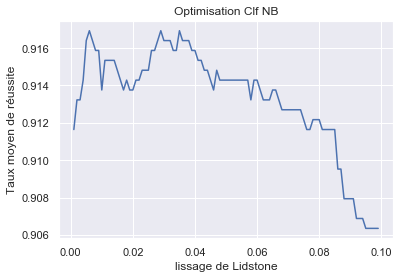

In [15]:
#Test sur le classifieur naïf Bayésien
import matplotlib.pyplot as plt
import numpy as np

def testNBParamAlpha(x):
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=x)),
    ])
    text_clf.fit(twenty_train.data, twenty_train.target)  
    return(np.mean(text_clf.predict(docs_test) == twenty_test.target))

#panorama des maxima de la courbe
#x=np.arange(0.001, 0.08, 0.001)

x=np.arange(0.001, 0.1, 0.001)#attention temps de calcul long (~5min)
y=[testNBParamAlpha(r) for r in x]

plt.plot(x, y)
plt.title("Optimisation Clf NB")
plt.xlabel("lissage de Lidstone")
plt.ylabel("Taux moyen de réussite")
plt.show()

In [18]:
#D'après la courbe ci dessus, on peut observer plusieurs maxima, nous prendrons par exemple alpha = 0.035
def ClfNB():
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=0.035)),
    ])
    text_clf.fit(twenty_train.data, twenty_train.target)  
    return(np.mean(text_clf.predict(docs_test) == twenty_test.target))

ClfNB()

0.9169312169312169

### 5.2. Classifieur par descente de gradients
###### Documentation sur les Descente de Gradient : 

Documentation sur la partie Théorique de la Descente de Gradients :

https://scikit-learn.org/stable/modules/sgd.html

Documentation sur la fonction SGDClassifier() :

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

### Concernant l'algorithme de Descente de gradients
il contient 22 hyperparamètres... :

###### loss : str, default: ‘hinge’

    The loss function to be used. Defaults to ‘hinge’.

    The possible options are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’.

    ‘hinge’ loss gives a linear SVM.
    ‘log’ loss gives logistic regression, a probabilistic classifier.
    ‘modified_huber’ is another smooth loss that brings tolerance to outliers as well as probability estimates.
    ‘squared_hinge’ is like hinge but is quadratically penalized.
    ‘perceptron’ is the linear loss used by the perceptron algorithm.
    The other losses are designed for regression but can be useful in classification as well; see SGDRegressor for a description.
###### penalty : str, ‘none’, ‘l2’, ‘l1’, or ‘elasticnet’

    The penalty (aka regularization term) to be used. Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model (feature selection) not achievable with ‘l2’.
###### alpha : float

    Constant that multiplies the regularization term. Defaults to 0.0001 Also used to compute learning_rate when set to ‘optimal’.
###### l1_ratio : float

    The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1. Defaults to 0.15.
###### fit_intercept : bool

    Whether the intercept should be estimated or not. If False, the data is assumed to be already centered. Defaults to True.
###### max_iter : int, optional

    The maximum number of passes over the training data (aka epochs). It only impacts the behavior in the fit method, and not the partial_fit. Defaults to 5. Defaults to 1000 from 0.21, or if tol is not None.

    New in version 0.19.
###### tol : float or None, optional

    The stopping criterion. If it is not None, the iterations will stop when (loss > previous_loss - tol). Defaults to None. Defaults to 1e-3 from 0.21.

    New in version 0.19.
###### shuffle : bool, optional

    Whether or not the training data should be shuffled after each epoch. Defaults to True.
###### verbose : integer, optional

    The verbosity level
###### epsilon : float

    Epsilon in the epsilon-insensitive loss functions; only if loss is ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’. For ‘huber’, determines the threshold at which it becomes less important to get the prediction exactly right. For epsilon-insensitive, any differences between the current prediction and the correct label are ignored if they are less than this threshold.
###### n_jobs : int or None, optional (default=None)

    The number of CPUs to use to do the OVA (One Versus All, for multi-class problems) computation. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.
###### random_state : int, RandomState instance or None, optional (default=None)

    The seed of the pseudo random number generator to use when shuffling the data. If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
###### learning_rate : string, optional

    The learning rate schedule:

    ‘constant’:

        eta = eta0
    ‘optimal’: [default]

        eta = 1.0 / (alpha * (t + t0)) where t0 is chosen by a heuristic proposed by Leon Bottou.
    ‘invscaling’:

        eta = eta0 / pow(t, power_t)
    ‘adaptive’:

        eta = eta0, as long as the training keeps decreasing. Each time n_iter_no_change consecutive epochs fail to decrease the training loss by tol or fail to increase validation score by tol if early_stopping is True, the current learning rate is divided by 5.

###### eta0 : double

    The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. The default value is 0.0 as eta0 is not used by the default schedule ‘optimal’.
###### power_t : double

    The exponent for inverse scaling learning rate [default 0.5].
###### early_stopping : bool, default=False

    Whether to use early stopping to terminate training when validation score is not improving. If set to True, it will automatically set aside a fraction of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.

    New in version 0.20.
###### validation_fraction : float, default=0.1

    The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True.

    New in version 0.20.
###### n_iter_no_change : int, default=5

    Number of iterations with no improvement to wait before early stopping.

    New in version 0.20.
###### class_weight : dict, {class_label: weight} or “balanced” or None, optional

    Preset for the class_weight fit parameter.

    Weights associated with classes. If not given, all classes are supposed to have weight one.

    The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
###### warm_start : bool, optional

    When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

    Repeatedly calling fit or partial_fit when warm_start is True can result in a different solution than when calling fit a single time because of the way the data is shuffled. If a dynamic learning rate is used, the learning rate is adapted depending on the number of samples already seen. Calling fit resets this counter, while partial_fit will result in increasing the existing counter.
###### average : bool or int, optional

    When set to True, computes the averaged SGD weights and stores the result in the coef_ attribute. If set to an int greater than 1, averaging will begin once the total number of samples seen reaches average. So average=10 will begin averaging after seeing 10 samples.
###### n_iter : int, optional

    The number of passes over the training data (aka epochs). Defaults to None. Deprecated, will be removed in 0.21.

    Changed in version 0.19: Deprecated

    
### Maintenant que nous avons passé en revue tous les hyperparamètres et après quelques essaies,
nous remarquons que 

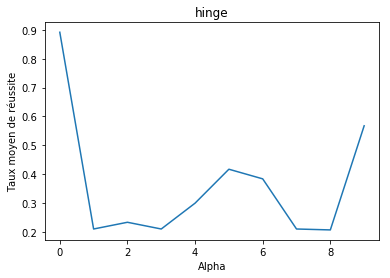

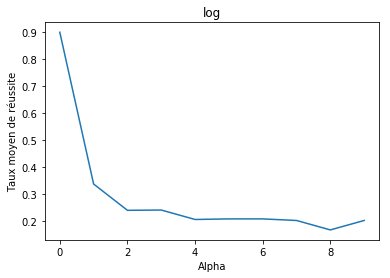

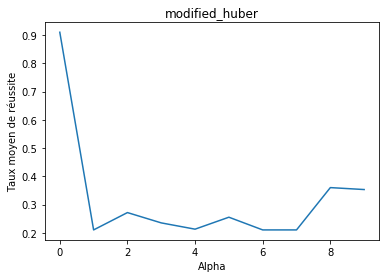

C:\Users\et8ge\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


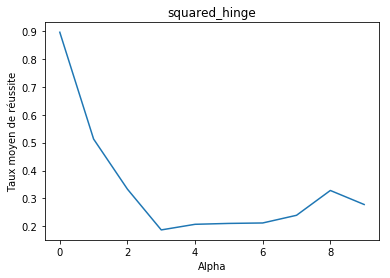

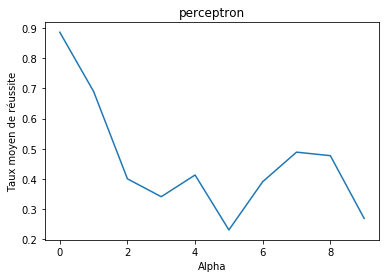

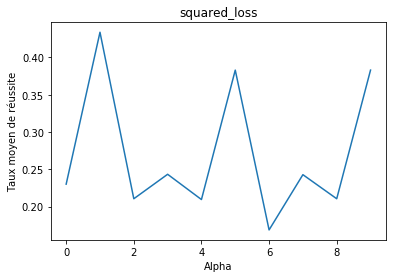

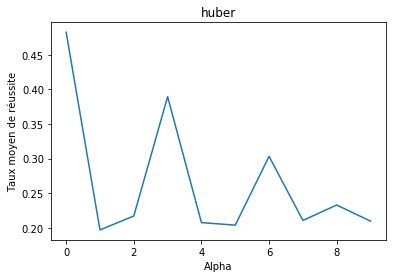

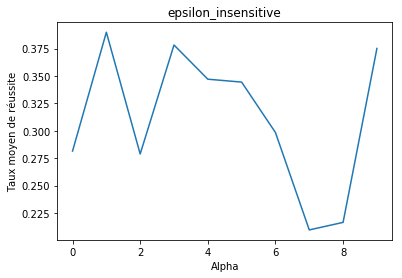

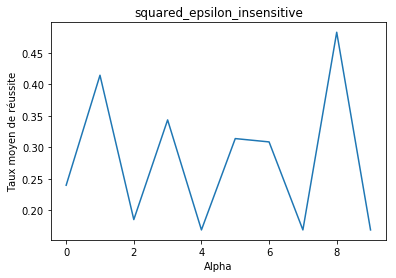

In [29]:
#Importation de la fonction depuis la librairie de SKLearn
from sklearn.linear_model import SGDClassifier
import numpy as np
import matplotlib.pyplot as plt

loss=["hinge",
      "log",
      "modified_huber",
      "squared_hinge",
      "perceptron",
      "squared_loss",
      "huber",
      "epsilon_insensitive",
      "squared_epsilon_insensitive"]

alpha=np.arange(0.000001, 10, 1)

def ClfSGDC(a,b):
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss=a,
                              alpha=b,
                              tol=0.21,
                              max_iter=5)),
    ])

    text_clf.fit(twenty_train.data, twenty_train.target)  

    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))

for r in loss :
    y=[ClfSGDC(r,f) for f in alpha]
    plt.plot(alpha, y)
    plt.title(r)
    plt.xlabel("Alpha")
    plt.ylabel("Taux moyen de réussite")
    plt.show()

In [31]:
#Importation de la fonction depuis la librairie de SKLearn
from sklearn.linear_model import SGDClassifier

# Test des hyperparamètres de la fonction

loss=["hinge", "log", "modified_huber", "squared_hinge", "perceptron", "squared_loss", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]


def ClfSGDC(x):
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss=x, max_iter=100, tol=None)),
    ])

    text_clf.fit(twenty_train.data, twenty_train.target)  

    predicted = text_clf.predict(docs_test)
    return(np.around(np.mean(predicted == twenty_test.target), 4)*100)

y=[ClfSGDC(x) for x in loss]

for n, p in zip (loss, y) :
    print('%r : %s' % (n, p))

'hinge' : 91.64
'log' : 90.48
'modified_huber' : 91.64
'squared_hinge' : 70.21
'perceptron' : 86.88
'squared_loss' : 20.419999999999998
'huber' : 90.53
'epsilon_insensitive' : 91.47999999999999
'squared_epsilon_insensitive' : 18.990000000000002


In [19]:
#Importation de la fonction depuis la librairie de SKLearn
from sklearn.linear_model import SGDClassifier

def ClfSGDC():
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=100, tol=None)),
    ])

    text_clf.fit(twenty_train.data, twenty_train.target)  

    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))

ClfSGDC()

0.9058201058201059

### 5.3. K-NN
###### Documentation sur le k-Nearest Neighbors : 

Documentation sur la partie Théorique du k-NN :

https://scikit-learn.org/stable/modules/neighbors.html

Documentation sur la fonction KNeighborsClassifier() :

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

### Concernant l'algorithme K-NN
il contient 8 hyperparamètres :
###### n_neighbors (!=0) : int
    Ce parametre permet de définir le nombre de cluster que nous allons lancé par l'algo

###### weights : 'uniform'(par défaut)/'distance'/'callable'
    Permet de gérer la pondération des différents points par rapport à leur k.
        'uniform' : Possibilité de choisir entre une pondération uniforme (par défaut),
        'distance' : pondéré par l'inverse de leur distance à k (donnant ainsi plus de poids au points les plus proche de k).
        'calable' : permet de personaliser les pondération en émettant un array en supplément du mot clé.
    
###### algorithm : 'auto'/''ball_tree/'kd_tree'/'brute' 
    permet d'utiliser différentes méthodes de calcul des k-NN.
        'auto' : méthode standard
        'ball_tree' : utilise la méthode ball tree
        (Doc : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)
        'kd_tree' : utilise la méthode kd tree
        (Doc : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)
        'brute' : utilise une méthode de recherche de type force_brute...
    
###### leaf_size : int
    Il s'agit ici de paramètres pour les méthodes de type ball-tree ou kd-tree. Ce paramètre permet d'optimiser le temps de calcul des méthodes précédentes.
    
###### p : int (1,2)
    Permet de gérer la facon de calculer les distances entre les points et leur k.
    1 permet d'utiliser la méthode de Manhattan, tandis que le 2 permet d'utiliser la méthode Euclidienne.
    
###### metric : string or callable
    toujours en relation avec les méthodes d'arbre ball ou kd, ce paramètre permet de gérer les métriques de distance entre les points et leur k.
    
###### metric_params : dictionnaire
    s'ajoute en complément du paramètre metric.
    
###### n_jobs : int
    permet de paralléliser les taches entre les différents processeurs.
    
### Maintenant que nous avons passé en revue tous les hyperparamètres et après quelques essaies,
nous remarquons que les seuls utilisables sont le nb de k, les poids (distance ou uniform), algo (uniquement : brute)
    

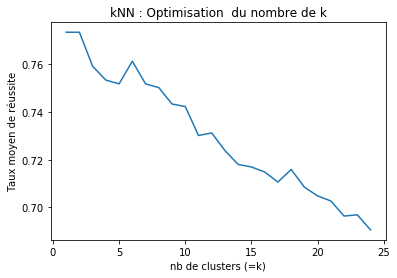

In [27]:
#Importation de la fonction depuis la librairie de SKLearn
from sklearn.neighbors import KNeighborsClassifier

def testKNNParamK(x):
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors = x, weights = 'distance'))])
    text_clf.fit(twenty_train.data, twenty_train.target)  
    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))

x=np.arange(1, 25, 1)
y=[testKNNParamK(r) for r in x]

plt.plot(x, y)
plt.title("kNN : Optimisation  du nombre de k")
plt.xlabel("nb de clusters (=k)")
plt.ylabel("Taux moyen de réussite")
plt.show()

# Supposition : En effet, on peut prédire le résultat de la courbe ci-dessous.
# Les vecteurs de textes correspondant à un label en particulier seront mieux ciblés par un unique k.
# De toute façon, au vue des réultats, il semblerait que la méthode kNN ne soit pas adaptée à notre problème !

# Que l'on utilise des poids uniform ou en fonction des distances, le maximum en k=1 est le même (77.35%).

In [29]:
r=[1,2,3,4,5] #Valeur de k

y=[np.around(testKNNParamK(x),4) for x in r]

for n, p in zip (r, y) :
    print('%r : %s' % (n, p))

1 : 0.7735
2 : 0.7735
3 : 0.7593
4 : 0.7534
5 : 0.7519


In [30]:
def ClfKnn():
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors = 1, weights = 'uniform'))])

    text_clf.fit(twenty_train.data, twenty_train.target)  
    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))

ClfKnn()

0.7735449735449735

### 5.4. Arbre de décision
###### Documentation sur les Arbres de décisisons : 

Documentation sur la partie Théorique des Arbres de décisions :

https://scikit-learn.org/stable/modules/tree.html

Documentation sur la fonction DecisionTreeClassifier() :

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### Concernant l'Arbre de décision
il contient 13 hyperparamètres :


#### criterion : string, optional (default=”gini”)

    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
#### splitter : string, optional (default=”best”)

    The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.
#### max_depth : int or None, optional (default=None)

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
#### min_samples_split : int, float, optional (default=2)

    The minimum number of samples required to split an internal node:

        If int, then consider min_samples_split as the minimum number.
        If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

    Changed in version 0.18: Added float values for fractions.
#### min_samples_leaf : int, float, optional (default=1)

    The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

        If int, then consider min_samples_leaf as the minimum number.
        If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

    Changed in version 0.18: Added float values for fractions.
#### min_weight_fraction_leaf : float, optional (default=0.)

    The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
#### max_features : int, float, string or None, optional (default=None)

    The number of features to consider when looking for the best split:

            If int, then consider max_features features at each split.
            If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
            If “auto”, then max_features=sqrt(n_features).
            If “sqrt”, then max_features=sqrt(n_features).
            If “log2”, then max_features=log2(n_features).
            If None, then max_features=n_features.

    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.
#### random_state : int, RandomState instance or None, optional (default=None)

    If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
#### max_leaf_nodes : int or None, optional (default=None)

    Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
#### min_impurity_decrease : float, optional (default=0.)

    A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

    The weighted impurity decrease equation is the following:

    N_t / N * (impurity - N_t_R / N_t * right_impurity
                        - N_t_L / N_t * left_impurity)

    where N is the total number of samples, N_t is the number of samples at the current node, N_t_L is the number of samples in the left child, and N_t_R is the number of samples in the right child.

    N, N_t, N_t_R and N_t_L all refer to the weighted sum, if sample_weight is passed.

    New in version 0.19.
#### min_impurity_split : float, (default=1e-7)

    Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

    Deprecated since version 0.19: min_impurity_split has been deprecated in favor of min_impurity_decrease in 0.19. The default value of min_impurity_split will change from 1e-7 to 0 in 0.23 and it will be removed in 0.25. Use min_impurity_decrease instead.
#### class_weight : dict, list of dicts, “balanced” or None, default=None

    Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.

    Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict. For example, for four-class multilabel classification weights should be [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of [{1:1}, {2:5}, {3:1}, {4:1}].

    The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

    For multi-output, the weights of each column of y will be multiplied.

    Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.
#### presort : bool, optional (default=False)

    Whether to presort the data to speed up the finding of best splits in fitting. For the default settings of a decision tree on large datasets, setting this to true may slow down the training process. When using either a smaller dataset or a restricted depth, this may speed up the training.

    
### Maintenant que nous avons passé en revue tous les hyperparamètres et après quelques essaies,
nous remarquons que 

In [80]:
#Importation de la fonction depuis la librairie de SKLearn
from sklearn.tree import DecisionTreeClassifier

def ClfDT():
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier(criterion="gini",
                                       splitter="best",
                                       max_depth=None,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       min_weight_fraction_leaf=0.0,
                                       max_features=None,
                                       random_state=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       class_weight=None,
                                       presort=False))])

    text_clf.fit(twenty_train.data, twenty_train.target)  
    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))

ClfDT()

0.7084656084656085

### 5.5. Forêt Aléatoire
###### Documentation sur les Forêts Aléatoires : 

Documentation sur la partie Théorique des Forêts Aléatoires :

https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

Documentation sur la fonction RandomForestClassifier() :

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Concernant les forets aléatoires :
il contient 13 hyperparamètres :



#### n_estimators : integer, optional (default=10)

    The number of trees in the forest.

    Changed in version 0.20: The default value of n_estimators will change from 10 in version 0.20 to 100 in version 0.22.
#### criterion : string, optional (default=”gini”)

    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.
#### max_depth : integer or None, optional (default=None)

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
#### min_samples_split : int, float, optional (default=2)

    The minimum number of samples required to split an internal node:

        If int, then consider min_samples_split as the minimum number.
        If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

    Changed in version 0.18: Added float values for fractions.
#### min_samples_leaf : int, float, optional (default=1)

    The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

        If int, then consider min_samples_leaf as the minimum number.
        If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

    Changed in version 0.18: Added float values for fractions.
#### min_weight_fraction_leaf : float, optional (default=0.)

    The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
#### max_features : int, float, string or None, optional (default=”auto”)

    The number of features to consider when looking for the best split:

        If int, then consider max_features features at each split.
        If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
        If “auto”, then max_features=sqrt(n_features).
        If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
        If “log2”, then max_features=log2(n_features).
        If None, then max_features=n_features.

    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.
#### max_leaf_nodes : int or None, optional (default=None)

    Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
#### min_impurity_decrease : float, optional (default=0.)

    A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

    The weighted impurity decrease equation is the following:

    N_t / N * (impurity - N_t_R / N_t * right_impurity
                        - N_t_L / N_t * left_impurity)

    where N is the total number of samples, N_t is the number of samples at the current node, N_t_L is the number of samples in the left child, and N_t_R is the number of samples in the right child.

    N, N_t, N_t_R and N_t_L all refer to the weighted sum, if sample_weight is passed.

    New in version 0.19.
#### min_impurity_split : float, (default=1e-7)

    Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

    Deprecated since version 0.19: min_impurity_split has been deprecated in favor of min_impurity_decrease in 0.19. The default value of min_impurity_split will change from 1e-7 to 0 in 0.23 and it will be removed in 0.25. Use min_impurity_decrease instead.
#### bootstrap : boolean, optional (default=True)

    Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.
#### oob_score : bool (default=False)

    Whether to use out-of-bag samples to estimate the generalization accuracy.
#### n_jobs : int or None, optional (default=None)

    Optimisation ! (not needed)
    The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.
#### random_state : int, RandomState instance or None, optional (default=None)

    If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
#### verbose : int, optional (default=0)

    Controls the verbosity when fitting and predicting.
#### warm_start : bool, optional (default=False)

    When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest. See the Glossary.
#### class_weight : dict, list of dicts, “balanced”, “balanced_subsample” or None, optional (default=None)

    Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.

    Note that for multioutput (including multilabel) weights should be defined for each class of every column in its own dict. For example, for four-class multilabel classification weights should be [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of [{1:1}, {2:5}, {3:1}, {4:1}].

    The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

    The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

    For multi-output, the weights of each column of y will be multiplied.

    Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

    
### Maintenant que nous avons passé en revue tous les hyperparamètres et après quelques essaies,
nous remarquons que 

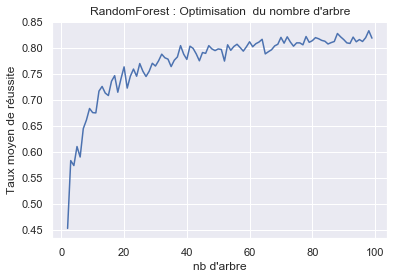

In [95]:
#Importation de la fonction depuis la librairie de SKLearn
from sklearn.ensemble import RandomForestClassifier

# Nous allons ici observer l'évolution du taux de réussite en fonction du nombre d'arbres contenue dans la forêt

# ATTENTION !! TEMPS DE CALCUL TRES LONG ! ~15min
def ClfRF(x):
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(n_estimators=x,
                                       criterion="gini",
                                       max_depth=None,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       min_weight_fraction_leaf=0.0,
                                       max_features="auto",
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       bootstrap=True,
                                       oob_score=False,
#                                       n_jobs=None,  ce paramètre génère une erreur, rechercher la raison...
                                       random_state=None,
                                       verbose=0,
                                       warm_start=False,
                                       class_weight=None))])

    text_clf.fit(twenty_train.data, twenty_train.target)
    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))


x=np.arange(2, 100, 1)
y=[ClfRF(r) for r in x]

plt.plot(x, y)
plt.title("RandomForest : Optimisation du nombre d'arbre")
plt.xlabel("nb d'arbres")
plt.ylabel("Taux moyen de réussite")
plt.show()

In [ ]:
#Le but ici est de 

### 5.6. Régréssion Logistique
###### Documentation sur la Regression Logistique : 

Documentation sur la partie Théorique de la Regression Logistique :

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Documentation sur la fonction LogisticRegression() :

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [66]:
#Importation de la fonction depuis la librairie de SKLearn
from sklearn.linear_model import LogisticRegression

def ClfRegLog():
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())])

    text_clf.fit(twenty_train.data, twenty_train.target)  
    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))

ClfRegLog()

0.8867724867724868

### 5.7. Machine à Vecteur de Support (SVM)
###### Documentation sur les Support Vecteur Machine (SVM), et notamment sur les SVC : 

Documentation sur la partie Théorique des Support Vecteur Machine :

https://scikit-learn.org/stable/modules/svm.html

Documentation sur la fonction SVC() :

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [67]:
#Importation de la fonction depuis la librairie de SKLearn
from sklearn.svm import SVC

def ClfSVC() :
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(kernel = 'linear'))])

    text_clf.fit(twenty_train.data, twenty_train.target)  

    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))

ClfSVC()

0.9079365079365079

# Boosting
Nous allons ici mettre en place un vote à la majorité simple.

In [68]:
from sklearn.ensemble import VotingClassifier

#Composition du méta-classifieur
metaClf = VotingClassifier(estimators=[('CLf1',MultinomialNB(alpha=0.035)),
                                       ('Clf2',SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=100, tol=None)),
                                       ('Clf3',KNeighborsClassifier(n_neighbors = 1, weights = 'uniform')),
                                       ('Clf4',DecisionTreeClassifier()),
                                       ('Clf5',RandomForestClassifier()),
                                       ('Clf6',LogisticRegression()),
                                       ('Clf7',SVC(kernel = 'linear'))],
                            voting="hard")

#Pipeline du méta-classifieur
def ClfMeta() :
    text_clf = Pipeline([
        ('tovect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', metaClf)])

    text_clf.fit(twenty_train.data, twenty_train.target)  

    predicted = text_clf.predict(docs_test)
    return(np.mean(predicted == twenty_test.target))


ClfMeta()

C:\Users\et8ge\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9137566137566138

# Evaluation du modèle complet (boosting) via matrice de confusion
Nous allons maintenant ré-évaluer notre modèle grâce à une matrice de confusion et quelques indicateurs(...)

In [69]:
from sklearn import metrics

print(metrics.classification_report(twenty_test.target, predicted, target_names=twenty_train.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.98      0.59      0.74       319
comp.sys.ibm.pc.hardware       0.88      0.91      0.90       392
   comp.sys.mac.hardware       0.92      0.86      0.89       385
                 sci.med       0.96      0.81      0.88       396
  soc.religion.christian       0.66      0.99      0.79       398

             avg / total       0.87      0.84      0.84      1890



In [70]:
#Matrice de confusion brute.
print(metrics.confusion_matrix(twenty_test.target, predicted))

[[189   2   0   7 121]
 [  0 357  26   1   8]
 [  0  34 330   4  17]
 [  2  10   3 322  59]
 [  2   1   0   2 393]]


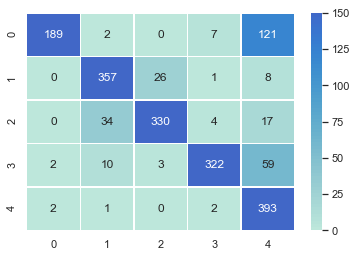

In [71]:
# importons une matrice de confusion un peu plus graphique et claire avec seaborn
import seaborn as sns

data=metrics.confusion_matrix(twenty_test.target, predicted)
ax = sns.heatmap(data, annot=True, fmt="d", linewidths=.5, vmin=0, vmax=150, center=300)